In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import random

def pflag(p,dt):
    return int(random.random()<p*dt)
def Tinf(aT,bT,T0,K,t,dt):
    q = K/(1e-5)
    ind = round(q*T0/dt)
    N = np.exp(aT*t)
    N[ind+1:] = N[ind+1]*np.exp(-bT*(t[ind+1:]-t[ind])) 
    return N

In [28]:
# -----------------------------
# Simulation parameters
# -----------------------------
dt = 3e-2                  # hours
Dend = 30 * 24              # hours (30 days)
M = int(round(Dend / dt)) + 1
t = np.arange(M) * dt


# -----------------------------
# T-cell parameters
# -----------------------------
NT = 500                    # number of T-cell clones
N0 = 10                     # baseline clone size (for non-powerlaw modes)

aT = 1 / 7.9
bT = 1 / 55
T0 = 2.5* 24               # hours (duration of proliferation)

sig = 0.20
mode = 2              # 0: neu, 1: aff, 2: num, 3: both


# -----------------------------
# Clone size distribution (truncated power law)
# -----------------------------
alpha = 2.2
N_min = 1.8
N_max = 1e4


def sample_truncated_powerlaw(n, alpha, xmin, xmax, rng):
    """Sample x ~ C x^{-alpha} on [xmin, xmax] (continuous), alpha != 1."""
    if xmin <= 0 or xmax <= xmin:
        raise ValueError("Require 0 < xmin < xmax.")
    if np.isclose(alpha, 1.0):
        raise ValueError("alpha=1 requires a log-form inverse CDF.")

    u = rng.random(n)
    p = 1.0 - alpha
    return (u * (xmax**p - xmin**p) + xmin**p) ** (1.0 / p)


def discretize_clone_sizes(x, xmin, xmax):
    """Round to integers and clip to [ceil(xmin), floor(xmax)]."""
    lo = int(np.ceil(xmin))
    hi = int(np.floor(xmax))
    return np.clip(np.rint(x), lo, hi).astype(int)


def init_Nvec_Kvec(mode, NT, N0, sig, alpha, N_min, N_max, K0=1e-5, rng=None):
    """
    Returns (Nvec, Kvec, trt) for modes:
      0: fixed N, fixed K
      1: fixed N, noisy K
      2: powerlaw N, fixed K
      3: powerlaw N, noisy K
    """
    rng = np.random.default_rng() if rng is None else rng

    if mode in (0, 1):
        Nvec = np.full(NT, N0, dtype=float)
    elif mode in (2, 3):
        x = sample_truncated_powerlaw(NT, alpha=alpha, xmin=N_min, xmax=N_max, rng=rng)
        Nvec = discretize_clone_sizes(x, xmin=N_min, xmax=N_max).astype(float)
    else:
        raise ValueError("mode must be 0, 1, 2, or 3.")

    if mode in (0, 2):
        Kvec = np.full(NT, K0, dtype=float)
    else:  # (1, 3)
        Kvec = np.abs(K0 * rng.normal(loc=1.0, scale=sig, size=NT)).astype(float)

    trt_map = {0: "neu", 1: "aff", 2: "num", 3: "both"}
    return Nvec, Kvec, trt_map[mode]


Nvec, Kvec, trt = init_Nvec_Kvec(mode, NT, N0, sig, alpha, N_min, N_max)

# -----------------------------
# Virus / pMHC parameters
# -----------------------------
r0 = 1e-1
aV = 1e-1
gV = 1e-5
kappa = 1e-1
ST = 1e4
# -----------------------------
# Pre-allocate state arrays
# -----------------------------
T = np.zeros((NT, M), dtype=float)
V = np.zeros(M, dtype=float)
V[0] = 1e-9


/var/folders/zm/c02xmwfx58l3xfx_hgwyrdgw0000gn/T/ipykernel_70360/767169469.py:105: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(t_days, np.log10(y), "k", linewidth=0.1)
/var/folders/zm/c02xmwfx58l3xfx_hgwyrdgw0000gn/T/ipykernel_70360/767169469.py:125: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(t_days, np.log10(V), color="red")


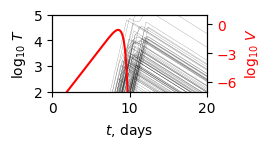

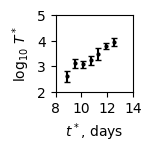

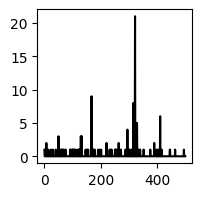

In [29]:
# -----------------------------
# Fit t* and f* with fixed a, b
# -----------------------------
def _log_shape(tt, tstar, a, b):
    """
    g(tt; t*) = log(2) - log(exp(-a (tt-t*)) + exp(b (tt-t*)))
    so that: log y(tt) ~= log f* + g(tt; t*)
    """
    dt = tt - tstar
    return np.log(2.0) - np.log(np.exp(-a * dt) + np.exp(b * dt))


def fit_tstar_fstar(t, y, a, b, bounds=None, y_min=1e-300):
    """
    Least-squares fit in log-space with fixed a,b:
        log y(t) ~= log f* + g(t; t*)
    For a given t*, the optimal log f* is mean(log y - g).
    Returns (tstar_hat, fstar_hat).
    """
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)

    mask = y > y_min
    if not np.any(mask):
        return np.nan, np.nan

    tt = t[mask]
    logy = np.log(y[mask])

    if bounds is None:
        bounds = (tt.min(), tt.max())

    def sse(tstar):
        g = _log_shape(tt, tstar, a, b)
        logf = np.mean(logy - g)
        r = (logf + g) - logy
        return np.sum(r * r)

    res = minimize_scalar(sse, bounds=bounds, method="bounded")
    tstar_hat = float(res.x)

    g = _log_shape(tt, tstar_hat, a, b)
    logf_hat = float(np.mean(logy - g))
    fstar_hat = float(np.exp(logf_hat))

    return tstar_hat, fstar_hat


# -----------------------------
# Stochastic model simulation
# -----------------------------
collector_t = []
collector_clone = []

Q = np.zeros(NT, dtype=float)

for i in range(M - 1):
    # inputs at time index i
    Tin = T[:, i]
    Vin = V[i]

    Sbar = ST * Vin / (Vin + kappa)

    denom = (Sbar + 1.0 / Kvec)
    p = r0 * Sbar * Nvec / (denom * (1.0 + np.sum(Nvec / denom)))

    act = np.array([pflag(r0 * x, dt) for x in p], dtype=float)
    Q += act

    # apply activations
    idx = np.where(act > 0.0)[0]
    for j in idx:
        collector_t.append(t[i])
        collector_clone.append(j)

        Tvec = Tinf(aT, bT, T0, Kvec[j], t, dt)
        T[j, i:] += Tvec[: (T.shape[1] - i)]

    # update V
    V[i + 1] = V[i] + dt * (aV * Vin * (1.0 - Vin) - gV * Vin * np.sum(Tin))
    if V[i + 1] < 1e-9:
        V[i + 1] = 0.0

    # clamp small T to 0 at next step
    T[T[:, i + 1] < 1.0, i + 1] = 0.0


# -----------------------------
# Fit t* and f* across clones
# -----------------------------
t_days = t / 24.0

Idd = np.round(24/dt)

Tstar_days = []
fstar = []

fig, ax1 = plt.subplots(figsize=(2, 1))

for y in T:
    y = np.asarray(y, dtype=float)
    if np.max(y) <= 1e2:
        continue

    ax1.plot(t_days, np.log10(y), "k", linewidth=0.1)

    tstar_hat, fstar_hat = fit_tstar_fstar(t, y, aT, bT)  # fit in hours
    Tstar_days.append(tstar_hat / 24.0)
    fstar.append(fstar_hat)

    # Tstar_days.append([t_days[i] for i, x in enumerate(y) if  x == np.max(y)])
    # fstar.append(np.max(y));

# axes styling (T)
ax1.set_xlabel(r"$t$, days")
ax1.set_ylabel(r"log$_{10}$ $T$", color="k")
ax1.tick_params(axis="y", labelcolor="k")
ax1.set_xlim(0, 20)
ax1.set_xticks([0, 10, 20])
ax1.set_ylim(2, 5)
ax1.set_yticks([2, 3, 4, 5])

# twin axis (V)
ax2 = ax1.twinx()
ax2.plot(t_days, np.log10(V), color="red")
ax2.set_ylabel(r"log$_{10}$ $V$", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(-7, 1)
ax2.set_yticks([-6, -3, 0])

fig.savefig(f'figs/Traj_and_viral_lvls_{trt}.svg')


# -----------------------------
# Bin log10(f*) vs t* and plot
# -----------------------------
edges = np.linspace(8, 14, 11)
centers = edges[1:] - 0.5 * (edges[1] - edges[0])

Tstar_days = np.asarray(Tstar_days, dtype=float)
fstar = np.asarray(fstar, dtype=float)

mean_logf = np.full(len(centers), np.nan)
sem_logf = np.full(len(centers), np.nan)

for k in range(len(centers)):
    in_bin = (Tstar_days >= edges[k]) & (Tstar_days < edges[k + 1]) & (fstar > 0)
    vals = np.log10(fstar[in_bin])

    if vals.size > 2:
        mean_logf[k] = np.mean(vals)
        sem_logf[k] = np.std(vals, ddof=1) / np.sqrt(vals.size)

plt.figure(figsize=(1, 1))
plt.errorbar(centers, mean_logf, sem_logf, fmt="k.", markersize=4, capsize=2)
plt.xlim(8, 14)
plt.xticks([8,10,12,14])
plt.ylim(2, 5)
plt.yticks([2, 3, 4, 5])
plt.xlabel(r"$t^*$, days")
plt.ylabel(r"log$_{10}$ $T^*$")
plt.savefig(f'figs/logTvtStar_{trt}.svg')


# -----------------------------
# Plot Q
# -----------------------------
plt.figure(figsize=(2, 2))
plt.plot(Q, "k")
